# Phase 1: Retinal Surface Detection (Both Volumes)

Clean, systematic processing of both OCT volumes for surface detection.

## Workflow:
1. Load both F001 volumes
2. Detect retinal surfaces using peak detection
3. Create MIP (Maximum Intensity Projection) for both
4. Save all outputs for Phase 2

## Setup and Imports

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from pathlib import Path
import sys
from scipy import ndimage
import time

# Add src to path
sys.path.append('../src')
from oct_volumetric_viewer import OCTImageProcessor, OCTVolumeLoader

# Configure matplotlib
plt.rcParams['figure.figsize'] = (15, 10)
plt.rcParams['image.cmap'] = 'gray'

print("✓ Imports successful")

✓ Imports successful


## Step 1: Find and Load Both F001 Volumes

In [2]:
# Find F001 volumes
data_dir = Path('../oct_data')

print("Searching for F001 OCT volumes...")
bmp_dirs = []
for bmp_file in data_dir.rglob('*.bmp'):
    vol_dir = bmp_file.parent
    if vol_dir not in bmp_dirs:
        bmp_dirs.append(vol_dir)

all_volume_dirs = sorted(bmp_dirs)
f001_vols = [v for v in all_volume_dirs if 'F001_IP' in str(v)]

if len(f001_vols) < 2:
    raise ValueError(f"Need 2 F001 volumes, found {len(f001_vols)}")

print(f"Found {len(f001_vols)} F001 volumes:")
print(f"  Volume 0: {f001_vols[0].name}")
print(f"  Volume 1: {f001_vols[1].name}")

# Initialize processor and loader
processor = OCTImageProcessor(sidebar_width=250, crop_top=50)
loader = OCTVolumeLoader(processor)

# Load both volumes
print("\nLoading volumes (this may take 1-2 minutes)...")
volume_0 = loader.load_volume_from_directory(str(f001_vols[0]))
volume_1 = loader.load_volume_from_directory(str(f001_vols[1]))

print(f"\n✓ Loaded both volumes:")
print(f"  Volume 0: {volume_0.shape}")
print(f"  Volume 1: {volume_1.shape}")

Searching for F001 OCT volumes...


2025-10-27 16:01:50,270 - INFO - Found 360 BMP files
2025-10-27 16:01:50,313 - INFO - Loading scan 1/360


Found 8 F001 volumes:
  Volume 0: F001_IP_20250604_175814_Retina_3D_L_6mm_1536x360_2
  Volume 1: F001_IP_20250604_180102_Retina_3D_L_6mm_1536x360_2

Loading volumes (this may take 1-2 minutes)...


2025-10-27 16:01:53,115 - INFO - Loading scan 51/360
2025-10-27 16:01:55,413 - INFO - Loading scan 101/360
2025-10-27 16:01:57,887 - INFO - Loading scan 151/360
2025-10-27 16:02:00,888 - INFO - Loading scan 201/360
2025-10-27 16:02:03,718 - INFO - Loading scan 251/360
2025-10-27 16:02:06,216 - INFO - Loading scan 301/360
2025-10-27 16:02:08,627 - INFO - Loading scan 351/360
2025-10-27 16:02:09,106 - INFO - Successfully loaded volume with shape (942, 1536, 360)
2025-10-27 16:02:09,109 - INFO - Found 360 BMP files
2025-10-27 16:02:09,151 - INFO - Loading scan 1/360
2025-10-27 16:02:12,386 - INFO - Loading scan 51/360
2025-10-27 16:02:14,749 - INFO - Loading scan 101/360
2025-10-27 16:02:17,434 - INFO - Loading scan 151/360
2025-10-27 16:02:19,977 - INFO - Loading scan 201/360
2025-10-27 16:02:22,338 - INFO - Loading scan 251/360
2025-10-27 16:02:24,733 - INFO - Loading scan 301/360
2025-10-27 16:02:27,099 - INFO - Loading scan 351/360
2025-10-27 16:02:27,574 - INFO - Successfully loaded 


✓ Loaded both volumes:
  Volume 0: (942, 1536, 360)
  Volume 1: (942, 1536, 360)


## Step 2: Visualize Sample B-Scans

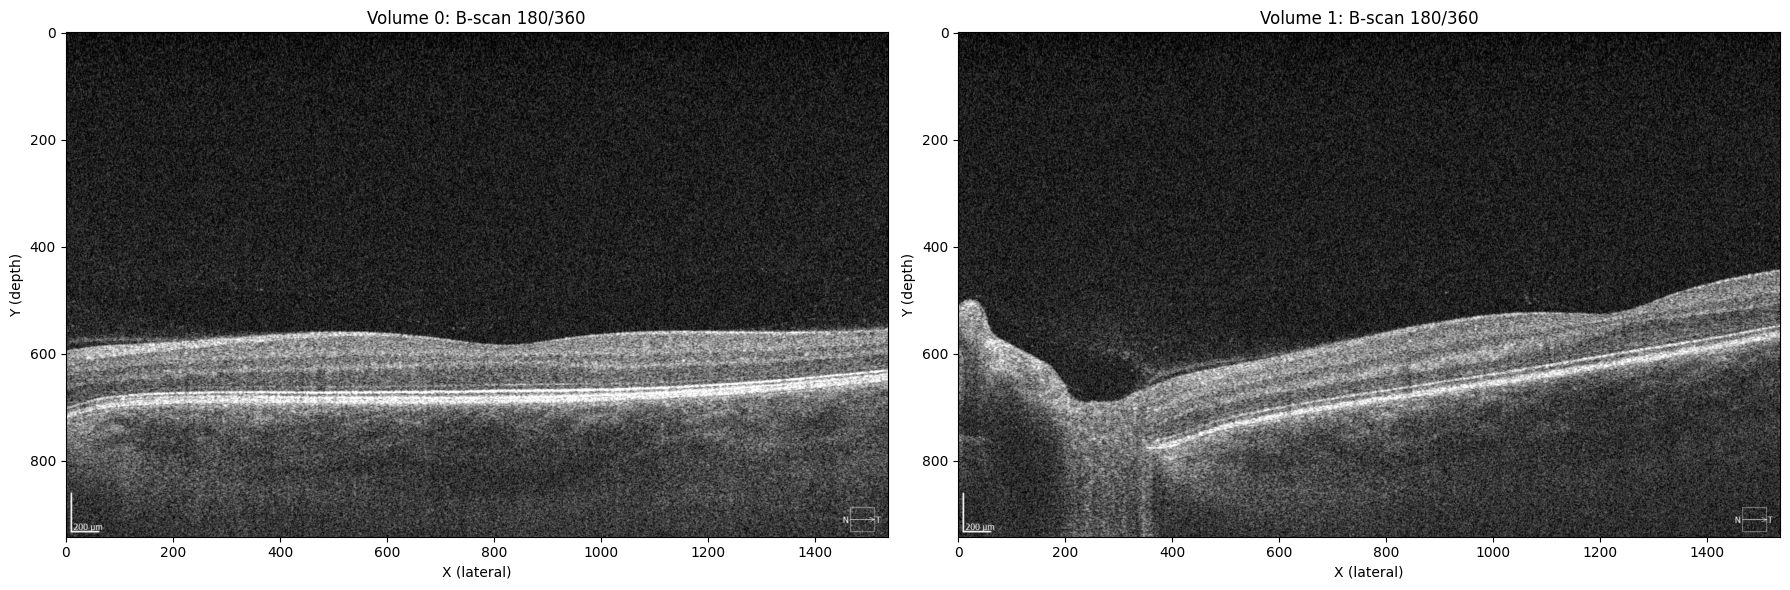

In [3]:
# Show center B-scan from both volumes
fig, axes = plt.subplots(1, 2, figsize=(18, 6))

mid_z = volume_0.shape[2] // 2

axes[0].imshow(volume_0[:, :, mid_z], aspect='auto')
axes[0].set_title(f'Volume 0: B-scan {mid_z}/{volume_0.shape[2]}')
axes[0].set_xlabel('X (lateral)')
axes[0].set_ylabel('Y (depth)')

axes[1].imshow(volume_1[:, :, mid_z], aspect='auto')
axes[1].set_title(f'Volume 1: B-scan {mid_z}/{volume_1.shape[2]}')
axes[1].set_xlabel('X (lateral)')
axes[1].set_ylabel('Y (depth)')

plt.tight_layout()
plt.show()

## Step 3: Surface Detection Functions

In [4]:
def create_mip(volume):
    """Maximum Intensity Projection along depth axis."""
    return np.max(volume, axis=0)

def detect_surface_peaks(volume, threshold_percentile=75, smooth_sigma=2):
    """
    Detect retinal surface by finding first peak in each A-scan.
    
    Returns:
        surface_heights: (W, D) array with surface Y-position for each A-scan
    """
    H, W, D = volume.shape
    surface_heights = np.zeros((W, D), dtype=np.int32)
    threshold = np.percentile(volume, threshold_percentile)
    
    for z in range(D):
        bscan = volume[:, :, z]
        if smooth_sigma > 0:
            bscan_smooth = ndimage.gaussian_filter(bscan, sigma=smooth_sigma)
        else:
            bscan_smooth = bscan
        
        for x in range(W):
            ascan = bscan_smooth[:, x]
            peaks = np.where(ascan > threshold)[0]
            surface_heights[x, z] = peaks[0] if len(peaks) > 0 else H // 2
    
    return surface_heights

print("✓ Functions defined")

✓ Functions defined


## Step 4: Process Both Volumes

In [5]:
print("Processing Volume 0...")
start = time.time()
mip_v0 = create_mip(volume_0)
surface_v0 = detect_surface_peaks(volume_0)
time_v0 = time.time() - start
print(f"  MIP: {mip_v0.shape}, Surface: {surface_v0.shape}")
print(f"  Time: {time_v0:.2f}s")

print("\nProcessing Volume 1...")
start = time.time()
mip_v1 = create_mip(volume_1)
surface_v1 = detect_surface_peaks(volume_1)
time_v1 = time.time() - start
print(f"  MIP: {mip_v1.shape}, Surface: {surface_v1.shape}")
print(f"  Time: {time_v1:.2f}s")

print(f"\n✓ Both volumes processed")

Processing Volume 0...
  MIP: (1536, 360), Surface: (1536, 360)
  Time: 18.00s

Processing Volume 1...
  MIP: (1536, 360), Surface: (1536, 360)
  Time: 18.16s

✓ Both volumes processed


## Step 5: Visualize Results

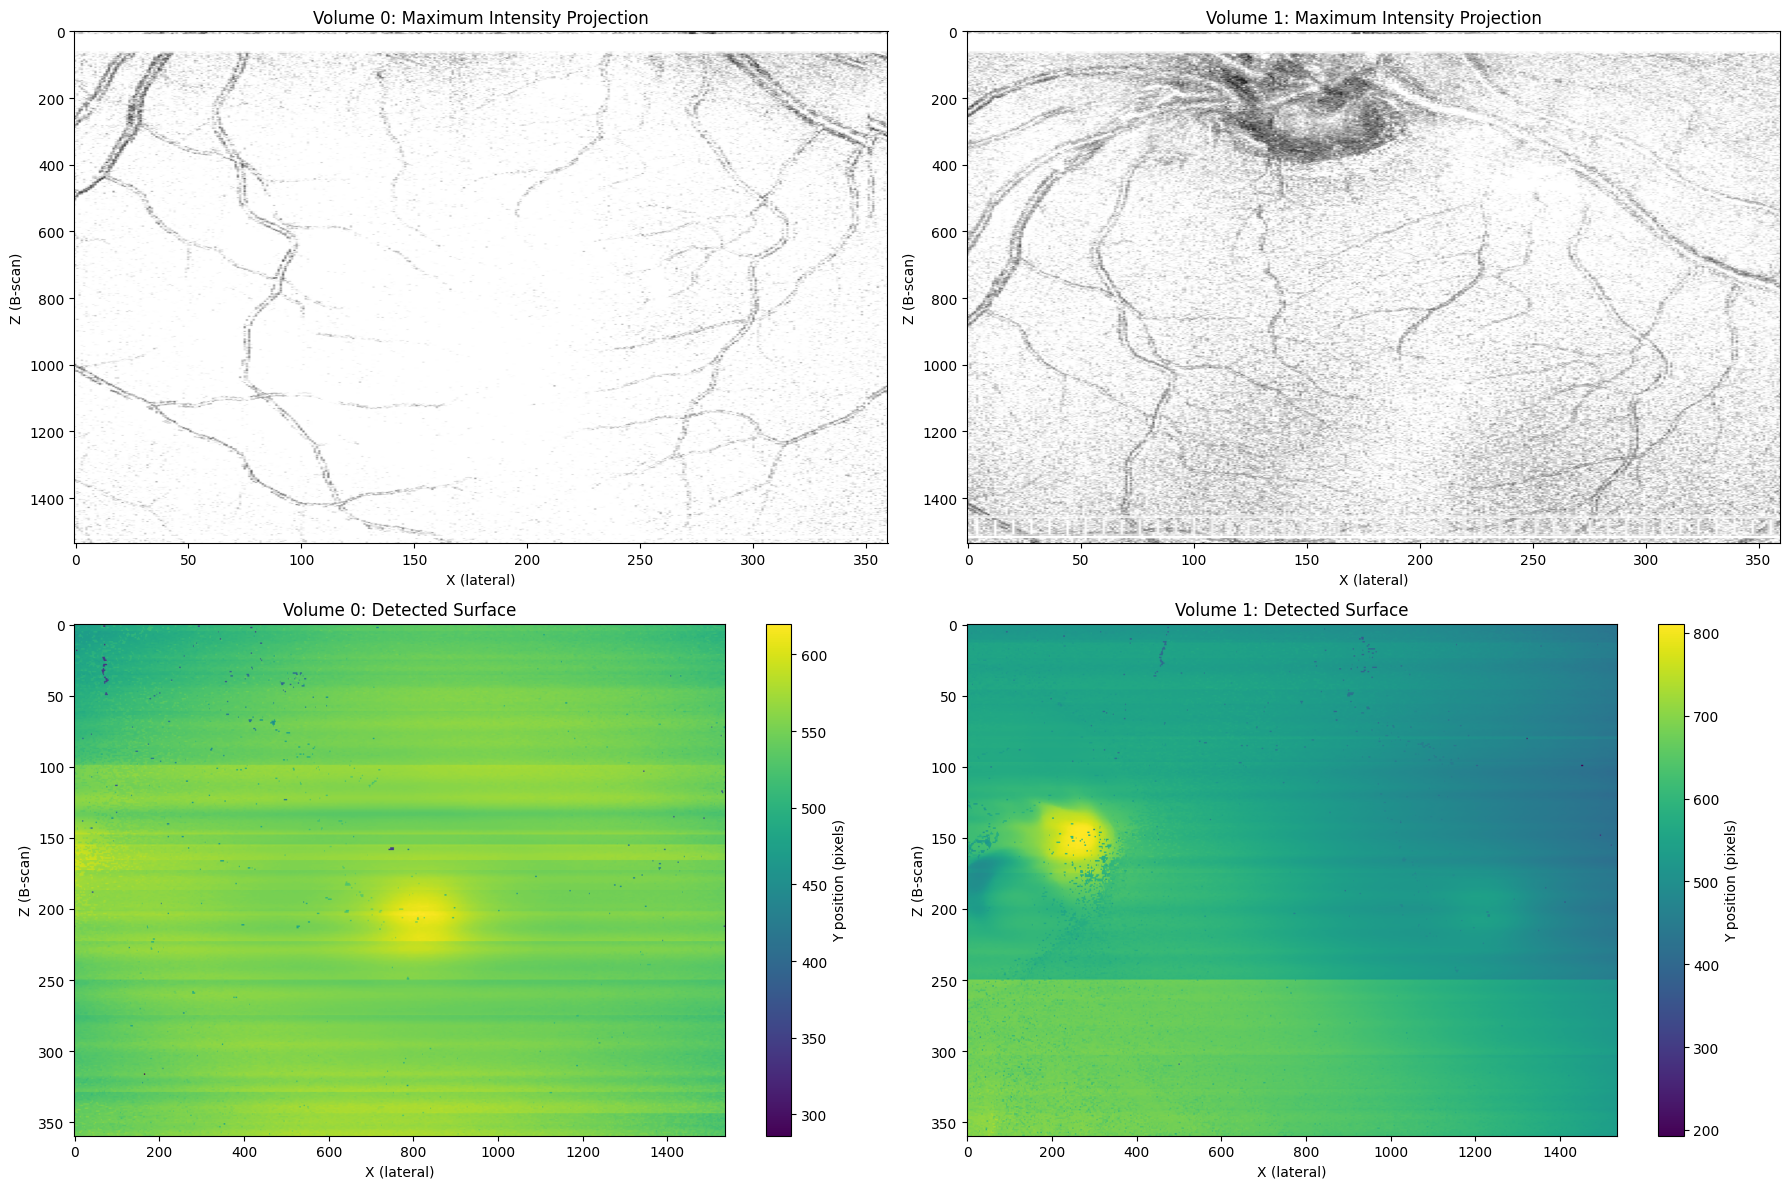

In [6]:
fig, axes = plt.subplots(2, 2, figsize=(18, 12))

# MIPs
axes[0, 0].imshow(mip_v0, aspect='auto')
axes[0, 0].set_title('Volume 0: Maximum Intensity Projection')
axes[0, 0].set_xlabel('X (lateral)')
axes[0, 0].set_ylabel('Z (B-scan)')

axes[0, 1].imshow(mip_v1, aspect='auto')
axes[0, 1].set_title('Volume 1: Maximum Intensity Projection')
axes[0, 1].set_xlabel('X (lateral)')
axes[0, 1].set_ylabel('Z (B-scan)')

# Surface heights
im0 = axes[1, 0].imshow(surface_v0.T, aspect='auto', cmap='viridis')
axes[1, 0].set_title('Volume 0: Detected Surface')
axes[1, 0].set_xlabel('X (lateral)')
axes[1, 0].set_ylabel('Z (B-scan)')
plt.colorbar(im0, ax=axes[1, 0], label='Y position (pixels)')

im1 = axes[1, 1].imshow(surface_v1.T, aspect='auto', cmap='viridis')
axes[1, 1].set_title('Volume 1: Detected Surface')
axes[1, 1].set_xlabel('X (lateral)')
axes[1, 1].set_ylabel('Z (B-scan)')
plt.colorbar(im1, ax=axes[1, 1], label='Y position (pixels)')

plt.tight_layout()
plt.show()

## Step 6: Verification on B-scans

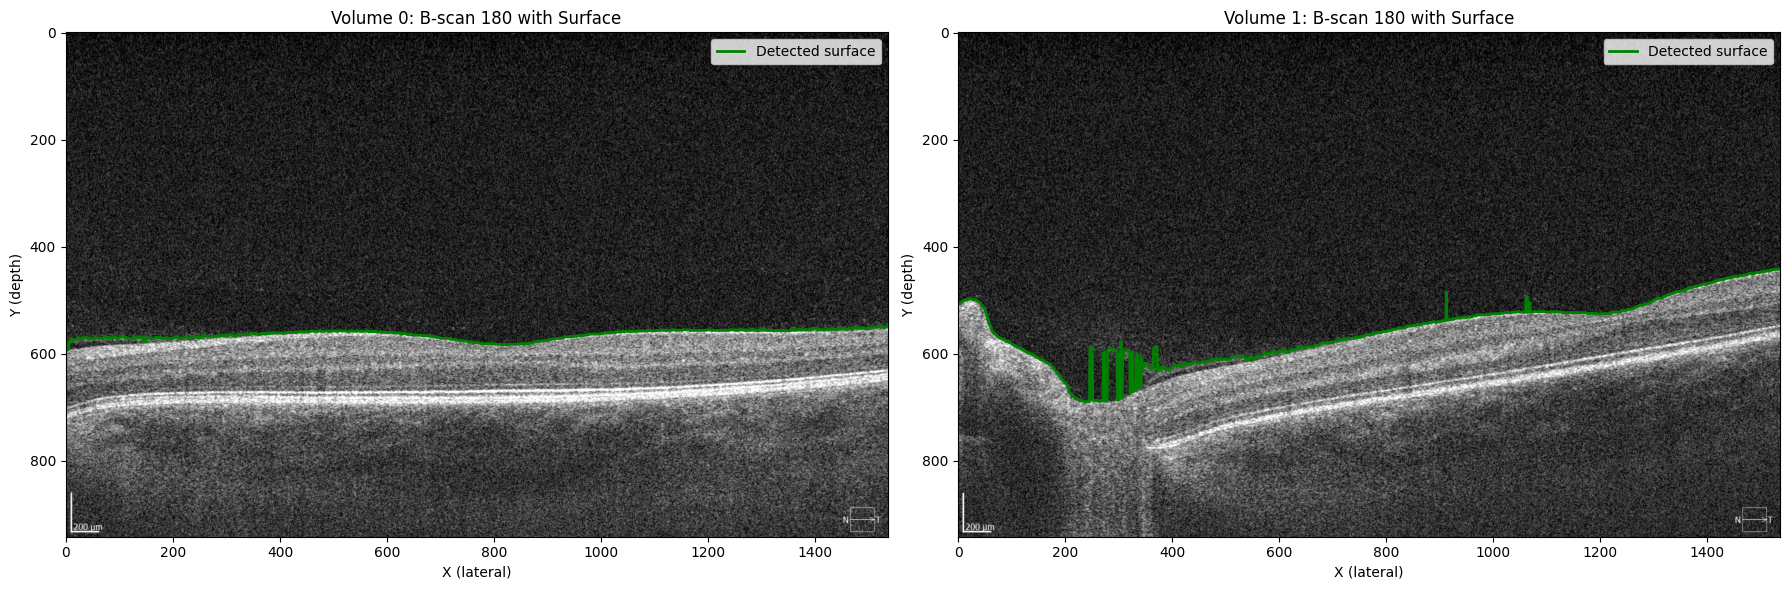

Surface height ranges:
  Volume 0: [286, 620] pixels
  Volume 1: [193, 811] pixels


In [7]:
# Verify surface detection on center B-scan
fig, axes = plt.subplots(1, 2, figsize=(18, 6))

mid_z = volume_0.shape[2] // 2

axes[0].imshow(volume_0[:, :, mid_z], aspect='auto')
axes[0].plot(range(volume_0.shape[1]), surface_v0[:, mid_z], 'g-', linewidth=2, label='Detected surface')
axes[0].set_title(f'Volume 0: B-scan {mid_z} with Surface')
axes[0].set_xlabel('X (lateral)')
axes[0].set_ylabel('Y (depth)')
axes[0].legend()

axes[1].imshow(volume_1[:, :, mid_z], aspect='auto')
axes[1].plot(range(volume_1.shape[1]), surface_v1[:, mid_z], 'g-', linewidth=2, label='Detected surface')
axes[1].set_title(f'Volume 1: B-scan {mid_z} with Surface')
axes[1].set_xlabel('X (lateral)')
axes[1].set_ylabel('Y (depth)')
axes[1].legend()

plt.tight_layout()
plt.show()

print(f"Surface height ranges:")
print(f"  Volume 0: [{surface_v0.min()}, {surface_v0.max()}] pixels")
print(f"  Volume 1: [{surface_v1.min()}, {surface_v1.max()}] pixels")

## Step 7: Save Results for Phase 2

In [8]:
# Save all results
output_dir = Path('data')
output_dir.mkdir(exist_ok=True)

# Volume 0
np.save(output_dir / 'enface_mip_volume0.npy', mip_v0)
np.save(output_dir / 'surface_peaks_volume0.npy', surface_v0)

# Volume 1
np.save(output_dir / 'enface_mip_volume1.npy', mip_v1)
np.save(output_dir / 'surface_peaks_volume1.npy', surface_v1)

print("✓ Saved all results:")
print(f"  Volume 0: enface_mip_volume0.npy, surface_peaks_volume0.npy")
print(f"  Volume 1: enface_mip_volume1.npy, surface_peaks_volume1.npy")
print(f"\n📋 Summary:")
print(f"  MIP shape: {mip_v0.shape}")
print(f"  Surface shape: {surface_v0.shape}")
print(f"\n✓ Phase 1 complete! Ready for Phase 2 (vessel segmentation).")

✓ Saved all results:
  Volume 0: enface_mip_volume0.npy, surface_peaks_volume0.npy
  Volume 1: enface_mip_volume1.npy, surface_peaks_volume1.npy

📋 Summary:
  MIP shape: (1536, 360)
  Surface shape: (1536, 360)

✓ Phase 1 complete! Ready for Phase 2 (vessel segmentation).
